## 1. Input

#### Data is stored in a Google sheet, sitting on my Google Drive. This script reads data from Google Sheet and returns a list of "about us" urls corresponding to businesses.

In [1]:
from os import getcwd
from os.path import join, abspath
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

def sheets_client():
    credentials_file = abspath(join(getcwd(), 'credentials.json'))
    credentials = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
    return gspread.authorize(credentials)

def sheets_get_all_websites():
    wks = sheets_client().open('Business websites').sheet1

    return [ 
        (row[0], row[2])      # Just client name and "about-us" urls needed.
        for row in wks.get_all_values()[1:]
    ]

def sheets_get_dataframe():
    wks = sheets_client().open('Business websites').sheet1

    return pd.DataFrame(wks.get_all_records())

In [2]:
client_data = sheets_get_all_websites()

## 2. Get keyphrases from about us pages

### 2a. EmbedRank

In [3]:
import rocky_config       # This is an in-house environment which enables jean packages and modules
from jean.nlp2.embedrank import embedrank
from jean.data.web import url2text
import pandas as pd

def get_embedrank_phrases(url):
    
    content = url2text(url)
    phrases = embedrank(content)
    
    data = [[i.text, i.score, i.aliases] for i in phrases]
    pd.set_option('display.max_colwidth', 0)
    df = pd.DataFrame.from_records(data, columns = ['Keyphrase', 'Score', 'Aliases'])
    
    return df

### 2b. IBM Watson NLU

In [4]:
import json
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 \
import Features, ConceptsOptions, KeywordsOptions, EntitiesOptions

In [5]:
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-03-16',
    #iam_api_key='RMcqA2KiX0OiyWFgXnEetnFV-he9-MQwmiJjTJRldFte',
    username = "4b5ce69c-5582-43bd-ac28-35ca8366eb9b",
    password = "KaIk6zlL3tcN",
    url  = "https://gateway.watsonplatform.net/natural-language-understanding/api"
)

In [6]:
def get_ibm_keyphrases(url):
    try:
        response_keyphrases = natural_language_understanding.analyze(
          url=url,
          features=Features(
            keywords=KeywordsOptions(
              sentiment=True,
              emotion=True,
              limit=10)))
    except:
        response_keyphrases = 0
        
    return response_keyphrases


def get_ibm_concepts(url):
    try:
        response_concepts = natural_language_understanding.analyze(
          url=url,
          features=Features(
            concepts=ConceptsOptions(
              limit=10)))
    except:
        response_concepts = 0
        
    return response_concepts



def get_ibm_entities(url):
    try:
        response_entities = natural_language_understanding.analyze(
          url=url,
          features=Features(
            entities=EntitiesOptions(
              sentiment=True,
              emotion=True,
              limit=10)))
    except:
        response_entities = 0
        
    return response_entities

In [7]:
#keyphrases
ibm_kp = get_ibm_keyphrases(client_data[0][1])['keywords']
data = [[i['text'], i['relevance']] for i in ibm_kp]
pd.DataFrame.from_records(data, columns = ['keyphrase', 'relevance'])

,keyphrase,relevance
0,RedZed Lending Solutions,0.988012
1,common sense approach,0.853351
2,mortgage partner look,0.836247
3,better way,0.725279
4,credit decisions,0.702969
5,Lighthouse Foundation,0.702810
6,rightful place,0.701346
7,youth homelessness,0.699385
8,loan expert,0.694931
9,vulnerable children,0.693298


In [8]:
ibm_en = get_ibm_entities(client_data[0][1])['entities']
data_en = [[i['text'], i['relevance'], i['type'], i['count']] for i in ibm_en]
pd.DataFrame.from_records(data_en, columns = ['entity', 'relevance', 'entity type', 'frequency'])

,entity,relevance,entity type,frequency
0,RedZed Lending Solutions,0.845405,Company,2
1,Lighthouse Foundation,0.460908,Organization,1
2,Lighthouse,0.410309,Company,1
3,partner,0.354174,JobTitle,1
4,Australia,0.334016,Location,1


In [9]:
ibm_con = get_ibm_concepts(client_data[0][1])['concepts']
data_con = [[i['text'], i['relevance'], i['dbpedia_resource']] for i in ibm_con]
pd.DataFrame.from_records(data_con, columns = ['concept', 'relevance', 'dbpedia link'])

,concept,relevance,dbpedia link
0,Debt,0.919186,http://dbpedia.org/resource/Debt
1,Credit,0.795683,http://dbpedia.org/resource/Credit
2,Interest,0.724839,http://dbpedia.org/resource/Interest
3,Predatory lending,0.672455,http://dbpedia.org/resource/Predatory_lending
4,Secured loan,0.672140,http://dbpedia.org/resource/Secured_loan
5,English-language films,0.662739,http://dbpedia.org/resource/English-language_f...
6,Youth,0.638040,http://dbpedia.org/resource/Youth
7,Bond,0.588756,http://dbpedia.org/resource/Bond_(finance)
8,Loan,0.559353,http://dbpedia.org/resource/Loan
9,Credit,0.558895,http://dbpedia.org/resource/Credit_(finance)


## 3. Query EventRegistry

#### 3a. API access

In [10]:
from eventregistry import *
from functional import pseq, seq

In [11]:
er = EventRegistry(apiKey = '42640197-4cec-40d7-9abf-264a4e7badea')

using user provided API key for making requests
Event Registry host: http://eventregistry.org
Text analytics host: http://analytics.eventregistry.org


#### 3b. Utilities around EventRegistry

In [12]:
#Separate keywords with and without dbpedia concepts
def concept_separation(keyword_list):
    words_noConceptUri = []
    words_withConceptUri = []

    for i in range(len(keyword_list)):
        temp = er.getConceptUri(keyword_list[i])
        try:
            if ' '.join(temp[-len(keyword_list[i]):].split('_')) != keyword_list[i] or temp is None:
                words_noConceptUri.append(keyword_list[i])
            
            else:
                words_withConceptUri.append(keyword_list[i])
        except:
            words_noConceptUri.append(keyword_list[i])
            
    return ([words_withConceptUri, words_noConceptUri])

In [13]:
def query_article(word_list_uri, words_noConcept, start, end):
    
    q = QueryArticles(
                    dateStart = start,
                    dateEnd = end,
                    conceptUri = QueryItems.OR(word_list_uri),
                    keywords = QueryItems.OR(words_noConcept),
                    lang = "eng")
            
    a = RequestArticlesInfo(page = 1,
                            count = 100,
                            sortBy = "rel", 
                            sortByAsc = False,
                            returnInfo = ReturnInfo(
                                                articleInfo = ArticleInfoFlags(
                                                                        concepts = True,
                                                                        url = True,
                                                                        title = True,
                                                                        body = True,  
                                                                        #dataType = True,
                                                                        sentiment = True,
                                                                        #source = True,
                                                                        categories = True,
                                                                        links = True,
                                                                        videos = True,
                                                                        #lang = True,
                                                                        location = True,
                                                                        #sim = True,
                                                                        #shares = True
                                                                                ), 
                                                conceptInfo = ConceptInfoFlags()
                                                    )
                           )
    
    q.setRequestedResult(a)
    
    return(er.execQuery(q))

In [14]:
#QueryArticles
def get_top_concepts(entities, last_month, last_week, p3):
    
    [words_withConceptUri, words_noConceptUri] = concept_separation(entities)
    word_list_uri = [er.getConceptUri(i) for i in entities]
    
    #Initializing
    q_res_combined = 0
    q_res_combined_lw = 0
    q_res_combined_p3 = 0
    
    #With Concepts and No concepts: 
    if last_month:
        print("Querying for last month.....")
        start = datetime.datetime.now() + datetime.timedelta(-28)
        end = datetime.datetime.now()
        q_res_combined = query_article(word_list_uri, words_noConceptUri, start, end)
        #q_res_combined = seq(list(q_res_combined['conceptAggr']['results']))
        
    if last_week:
        print("Querying for last week.....")
        start = datetime.datetime.now() + datetime.timedelta(-7)
        end = datetime.datetime.now()
        q_res_combined_lw = query_article(word_list_uri, words_noConceptUri, start, end)
        #q_res_combined_lw = seq(list(q_res_combined_lw['conceptAggr']['results']))
        
    if p3:
        print("Querying for 3 weeks before last week.....")
        start = datetime.datetime.now() + datetime.timedelta(-28)
        end = datetime.datetime.now() + datetime.timedelta(-8)
        q_res_combined_p3 = query_article(word_list_uri, words_noConceptUri, start, end)
        #q_res_combined_p3 = seq(list(q_res_combined_p3['conceptAggr']['results']))
      
    return ([q_res_combined, q_res_combined_lw, q_res_combined_p3, word_list_uri])

#### 3c. Query EventRegistry using IBM NLU's concepts

In [15]:
data_con = [i['text'] for i in ibm_con]
data_con = [i.lower() for i in data_con]

In [16]:
[q_month, q_lw, q_p3, word_list] = get_top_concepts(data_con, 0, 1, 1)

Querying for last week.....
Querying for 3 weeks before last week.....


In [17]:
# For articles in last week
data_articles = [[q_lw['articles']['results'][i]['date'], q_lw['articles']['results'][i]['time'], 
q_lw['articles']['results'][i]['dataType'], q_lw['articles']['results'][i]['url'],
q_lw['articles']['results'][i]['title'], #q_lw['articles']['results'][i]['body'],
q_lw['articles']['results'][i]['source']['title'], q_lw['articles']['results'][i]['location'],
q_lw['articles']['results'][i]['sentiment'], q_lw['articles']['results'][i]['wgt']] 
        for i in range(len(q_lw['articles']['results']))]

labels = ['date', 'time', 'dataType', 'url', 'title', 'source', 'location', 'sentiment', 'wgt']
df_lw = pd.DataFrame.from_records(data_articles, columns = labels)
df_lw.head(5)

,date,time,dataType,url,title,source,location,sentiment,wgt
0,2018-07-09,21:41:00,blog,https://articles.bplans.com/get-a-business-cre...,Get a Business Credit Card to Build Your Start...,Bplans Blog,None,None,365
1,2018-07-12,14:50:00,news,https://www.johnnyjet.com/check-credit-inquiri...,How To Check Credit Inquiries On Your Credit R...,Johnny Jet,None,None,306
2,2018-07-15,09:33:00,news,https://www.dailyrepublic.com/all-dr-news/wire...,How to get a credit card when you've never had...,Daily Republic,None,None,299
3,2018-07-10,19:20:00,blog,https://columbustelegram.com/business/investme...,"Should You Pay Off Debt, or Should You Save an...",Columbus Telegram,None,None,274
4,2018-07-12,18:56:00,blog,https://www.merchantmaverick.com/5-ways-improv...,5 Ways To Improve Your Personal Credit Score |...,Merchant Maverick,None,None,270


In [18]:
# For articles in 3 weeks before last week
data_p3 = [[q_p3['articles']['results'][i]['date'], q_p3['articles']['results'][i]['time'], 
q_p3['articles']['results'][i]['dataType'], q_p3['articles']['results'][i]['url'],
q_p3['articles']['results'][i]['title'], #q_lw['articles']['results'][i]['body'],
q_p3['articles']['results'][i]['source']['title'], q_p3['articles']['results'][i]['location'],
q_p3['articles']['results'][i]['sentiment'], q_p3['articles']['results'][i]['wgt']] 
        for i in range(len(q_p3['articles']['results']))]

labels = ['date', 'time', 'dataType', 'url', 'title', 'source', 'location', 'sentiment', 'wgt']
df_p3 = pd.DataFrame.from_records(data_articles, columns = labels)

## 4. Analyze and Rank the news articles according to cosine similarity with the URL's content

#### 4a. date wise count of articles 

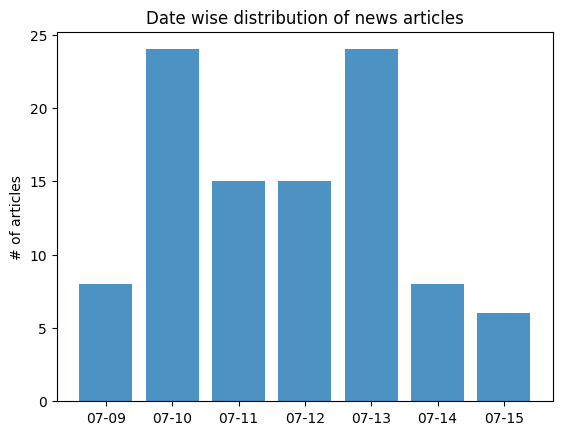

In [24]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = [i[5:] for i in sorted(list(set(df_lw['date'])))]
y_pos = np.arange(len(objects))
performance = list(df_lw.groupby('date').size())
 
plt.bar(y_pos, performance, alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('# of articles')
plt.title('Date wise distribution of news articles')
 
plt.show()

#### 4b. time wise count of articles - group by morning, afternoon and evening

In [27]:
morning = 0
afternoon = 0
evening = 0

for i in range(len(df_lw['time'])):
    if df_lw['time'][i] >= '00:00:00' and df_lw['time'][i] <= '12:00:00':
        morning = morning + 1
    elif df_lw['time'][i] > '12:00:00' and df_lw['time'][i] <= '18:00:00':
        afternoon = afternoon + 1
    else:
        evening = evening + 1

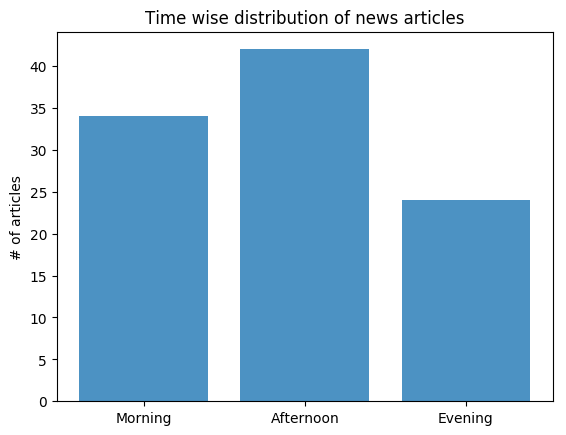

In [28]:
objects = ['Morning', 'Afternoon', 'Evening']
y_pos = np.arange(len(objects))
performance = [morning, afternoon, evening]
 
plt.bar(y_pos, performance, alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('# of articles')
plt.title('Time wise distribution of news articles')
 
plt.show()

#### 4c. data type wise count - pr, news, blog

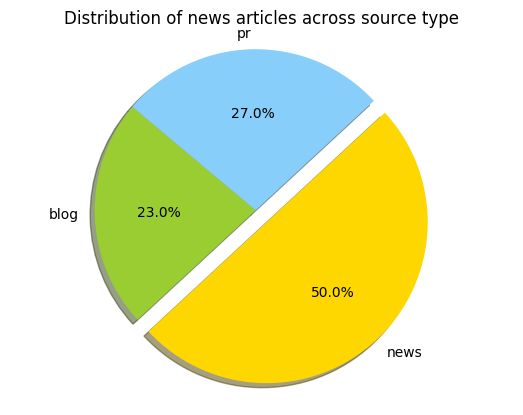

In [37]:
import matplotlib.pyplot as plt
 
labels = sorted(list(set(df_lw['dataType'])))
sizes = list(df_lw.groupby('dataType').size())
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0, 0.1 , 0 )  # explode 1st slice
 
# Plot
plt.pie(sizes, explode = explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Distribution of news articles across source type')
plt.axis('equal')
plt.show()

#### 4d. source count

In [38]:
len(set(df_lw['source']))

53

#### 4e. cosine similarity with title, docemb of content

In [39]:
from jean.nlp2.embeddings import embed_document, embed_text
from sklearn.metrics.pairwise import cosine_similarity
from jean.data.web import url2text

titles = list(df_lw['title'])

emb_titles = [embed_text(i) for i in titles]

content = url2text(client_data[0][1])
doc_emb = embed_document(content)

sims_titles = [float(cosine_similarity(doc_emb, i.reshape(1,-1))) for i in emb_titles]

#ranked_titles = [x for _,x in sorted(zip(sims_titles,titles), reverse = True)]
data = [[titles[i], sims_titles[i]] for i in range(len(sims_titles))]
df_ranked = pd.DataFrame.from_records(data, columns = ['title', 'relevance']).sort_values(by = ['relevance'], ascending = False)
df_ranked[:10]

,title,relevance
64,Deduction U/s. 80P(2)(d) eligible to Co-operat...,0.417757
60,Remodeling your home? Good credit offers a str...,0.413251
99,How do late payments affect your credit score?,0.387905
54,"New grads, unlock your future with a credit ch...",0.351911
55,"New grads, unlock your future with a credit ch...",0.351911
11,Can Delhi HC decision block migration of KKC?,0.351008
92,Should you have multiple credit cards? Here ar...,0.350186
93,Smart ways to evaluate your credit score,0.343396
20,4 ways to build good credit without using a cr...,0.333768
47,One way to beat the system when claiming tax b...,0.311758


#### 4f. Topic Modelling on article Titles from last week and 3 weeks before last week

In [66]:
#clean article titles
titles_p3 = list(df_p3['title'])

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

clean_lw = [clean(doc).split() for doc in titles] 
clean_p3 = [clean(doc).split() for doc in titles_p3] 

In [67]:
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_lw = corpora.Dictionary(clean_lw)
dictionary_p3 = corpora.Dictionary(clean_p3)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_lw = [dictionary_lw.doc2bow(doc) for doc in clean_lw]
doc_term_matrix_p3 = [dictionary_p3.doc2bow(doc) for doc in clean_p3]

In [73]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel_lw = Lda(doc_term_matrix_lw, num_topics=5, id2word = dictionary_lw, passes=50)
ldamodel_p3 = Lda(doc_term_matrix_p3, num_topics=5, id2word = dictionary_p3, passes=50)

In [74]:
ldamodel_lw.print_topics(num_topics=5, num_words=3)

[(0, '0.057*"credit" + 0.029*"score" + 0.015*"like"'),
 (1, '0.052*"credit" + 0.049*"report" + 0.043*"quarter"'),
 (2, '0.057*"credit" + 0.026*"score" + 0.016*"maverick"'),
 (3, '0.044*"credit" + 0.019*"tax" + 0.019*"improve"'),
 (4, '0.045*"2018" + 0.045*"second" + 0.045*"quarter"')]

In [75]:
import pyLDAvis.gensim
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel_lw, doc_term_matrix_lw, dictionary_lw, mds='tsne')
panel

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics          x           y
topic                                                   
1      34.762890        1       1  43.938137   44.475975
4      25.087034        1       2   2.613683 -130.187271
2      18.958033        1       3 -98.539513  -92.513298
0      12.063036        1       4 -50.497219    0.106957
3       9.129005        1       5  77.607246  -58.079666, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
74    Default  19.000000       second  19.000000  30.0000  30.0000
71    Default  19.000000      quarter  19.000000  29.0000  29.0000
22    Default  12.000000        score  12.000000  28.0000  28.0000
236   Default   5.000000         bank   5.000000  27.0000  27.0000
5     Default  36.000000       credit  36.000000  26.0000  26.0000
144   Default   7.000000    citigroup   7.000000  25.0000  25.0000
72    Default   7.000000       record   7.000000  24.0000  24.0000
251   Default   5.000000     republic   5.000000  23.0000  23.0000
248   Default   5.000000         fact   5.000000  22.0000  22.0000
249   Default   5.000000   surprising   5.000000  21.0000  21.0000
24    Default   5.000000        first   5.000000  20.0000  20.0000
13    Default  11.000000         debt  11.000000  19.0000  19.0000
47    Default  18.000000         2018  18.000000  18.0000  18.0000
10    Default  19.000000       report  19.000000  17.0000  17.0000
75    Default   6.000000       strong   6.000000  16.0000  16.0000
247   Default   4.000000       charge   4.000000  15.0000  15.0000
246   Default   4.000000      america   4.000000  14.0000  14.0000
250   Default   4.000000         take   4.000000  13.0000  13.0000
270   Default   4.000000    announces   4.000000  12.0000  12.0000
271   Default   4.000000       ozarks   4.000000  11.0000  11.0000
145   Default   9.000000    financial   9.000000  10.0000  10.0000
172   Default   2.000000          tax   2.000000   9.0000   9.0000
18    Default   2.000000      improve   2.000000   8.0000   8.0000
40    Default   1.000000      partner   1.000000   7.0000   7.0000
19    Default   2.000000     maverick   2.000000   6.0000   6.0000
20    Default   2.000000     merchant   2.000000   5.0000   5.0000
43    Default   8.000000        share   8.000000   4.0000   4.0000
128   Default   2.000000         like   2.000000   3.0000   3.0000
154   Default   1.000000          may   1.000000   2.0000   2.0000
26    Default   1.000000  millennials   1.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
185    Topic5   0.683601     everyone   1.249301   1.7907  -4.5920
184    Topic5   0.683601        bring   1.249301   1.7907  -4.5920
187    Topic5   0.683601       uphold   1.249301   1.7907  -4.5920
221    Topic5   0.683600   remodeling   1.249301   1.7907  -4.5920
219    Topic5   0.683600   foundation   1.249301   1.7907  -4.5920
208    Topic5   0.683600       weekly   1.249301   1.7907  -4.5920
204    Topic5   0.683600   commentary   1.249301   1.7907  -4.5920
127    Topic5   0.683599        whats   1.249302   1.7907  -4.5920
126    Topic5   0.683599          job   1.249302   1.7907  -4.5920
125    Topic5   0.683599        could   1.249302   1.7907  -4.5920
124    Topic5   0.683599         cost   1.249302   1.7907  -4.5920
91     Topic5   0.683599       rising   1.249302   1.7907  -4.5920
90     Topic5   0.683599      compare   1.249302   1.7907  -4.5920
89     Topic5   0.683599      average   1.249302   1.7907  -4.5920
172    Topic5   1.255342          tax   2.521340   1.6963  -3.9842
18     Topic5   1.254497      improve   2.521538   1.6956  -3.9849
5      Topic5   2.966309       credit  36.703712  -0.1218  -3.1243
111    Topic5   0.686939      divorce   2.023209   1.3135  -4.5871
23     Topic5   0.685679          way   3.339606   0.8105  -4.5889
39     Topic5   0.685583         loan   6.225137   0.1876  -4.5891
97     

In [77]:
ldamodel_p3.print_topics(num_topics=5, num_words=3)

[(0, '0.070*"credit" + 0.033*"score" + 0.022*"card"'),
 (1, '0.083*"credit" + 0.037*"score" + 0.034*"debt"'),
 (2, '0.033*"credit" + 0.023*"new" + 0.023*"egypt"'),
 (3, '0.064*"2018" + 0.057*"result" + 0.055*"report"'),
 (4, '0.041*"report" + 0.033*"credit" + 0.028*"record"')]

In [78]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel_p3, doc_term_matrix_p3, dictionary_p3, mds='tsne')
panel

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
3      30.935236        1       1   10.578105   15.464595
1      27.510786        1       2   48.990639 -113.106117
0      17.576231        1       3  -10.108997  -62.538857
4      17.451902        1       4  122.855019  -80.602036
2       6.525846        1       5   82.990738  -13.548595, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
73    Default  13.000000         result  13.000000  30.0000  30.0000
47    Default  18.000000           2018  18.000000  29.0000  29.0000
10    Default  19.000000         report  19.000000  28.0000  28.0000
22    Default  12.000000          score  12.000000  27.0000  27.0000
145   Default   9.000000      financial   9.000000  26.0000  26.0000
5     Default  36.000000         credit  36.000000  25.0000  25.0000
144   Default   7.000000      citigroup   7.000000  24.0000  24.0000
69    Default   4.000000            per   4.000000  23.0000  23.0000
71    Default  19.000000        quarter  19.000000  22.0000  22.0000
74    Default  19.000000         second  19.000000  21.0000  21.0000
72    Default   7.000000         record   7.000000  20.0000  20.0000
67    Default   4.000000            inc   4.000000  19.0000  19.0000
13    Default  11.000000           debt  11.000000  18.0000  18.0000
62    Default   8.000000       earnings   8.000000  17.0000  17.0000
170   Default   2.000000            new   2.000000  16.0000  16.0000
86    Default   3.000000     bancshares   3.000000  15.0000  15.0000
84    Default   3.000000            101   3.000000  14.0000  14.0000
87    Default   3.000000       commerce   3.000000  13.0000  13.0000
43    Default   8.000000          share   8.000000  12.0000  12.0000
249   Default   5.000000     surprising   5.000000  11.0000  11.0000
248   Default   5.000000           fact   5.000000  10.0000  10.0000
135   Default   1.000000          egypt   1.000000   9.0000   9.0000
194   Default   1.000000           grad   1.000000   8.0000   8.0000
193   Default   1.000000         future   1.000000   7.0000   7.0000
192   Default   1.000000        checkup   1.000000   6.0000   6.0000
195   Default   1.000000         unlock   1.000000   5.0000   5.0000
92    Default   1.000000            apr   1.000000   4.0000   4.0000
251   Default   5.000000       republic   5.000000   3.0000   3.0000
247   Default   4.000000         charge   4.000000   2.0000   2.0000
246   Default   4.000000        america   4.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
133    Topic5   0.594078      borrowing   1.171103   2.0507  -4.3966
134    Topic5   0.594078          daily   1.171103   2.0507  -4.3966
210    Topic5   0.594077           free   1.171103   2.0507  -4.3966
209    Topic5   0.594077           apps   1.171103   2.0507  -4.3966
211    Topic5   0.594077           stay   1.171103   2.0507  -4.3966
212    Topic5   0.594077            top   1.171103   2.0507  -4.3966
213    Topic5   0.594077       toprated   1.171103   2.0507  -4.3966
95     Topic5   0.594076           work   1.171103   2.0507  -4.3966
94     Topic5   0.594076  understanding   1.171103   2.0507  -4.3966
93     Topic5   0.594076        exactly   1.171103   2.0507  -4.3966
105    Topic5   0.594076           stop   1.171103   2.0507  -4.3966
104    Topic5   0.594076         paying   1.171103   2.0507  -4.3966
103    Topic5   0.594076        happens   1.171103   2.0507  -4.3966
170    Topic5   1.090855            new   2.428957   1.9289  -3.7889
137    Topic5   0.594472           news   1.856422   1.5907  -4.3960
117    Topic5   0.595348           need   2.656403   1.2338  -4.3945
106    Topic5   0.595184        student   3.304988   1.0151  -4.3948
39     Topic5   0.593855           loan   6.149187   0.3920  -4.3970
244    Topic5   0.099023        

#### 4g. cosine similarity with body, docemb of content

In [48]:
body = [q_lw['articles']['results'][i]['body'] for i in range(len(q_lw['articles']['results']))]

emb_body = [embed_document(i) for i in body]

sims_body = [float(cosine_similarity(doc_emb, i)) for i in emb_body]

data = [[titles[i], sims_body[i]] for i in range(len(sims_body))]
df_ranked = pd.DataFrame.from_records(data, columns = ['title', 'relevance']).sort_values(by = ['relevance'], ascending = False)
df_ranked[:10]

,title,relevance
22,What Happens When You Stop Paying Your Student...,0.742873
46,Senior Youth Workforce Development Advisor (Am...,0.734073
9,Farmland Partners: Loans To Related-Party Tena...,0.733826
81,American United FCU and Finex Credit Union to ...,0.729843
48,What The End Of The Credit Cycle May Look Like...,0.724607
50,Say Yes to Payday Loan Debt Consolidation - Ca...,0.722297
7,Wells Fargo Reports $5.2 Billion in Quarterly ...,0.716360
23,Credible Review: Is it Worth it to Refinance Y...,0.715146
51,Libra Credit and Uphold Partner to Bring Credi...,0.713195
88,"The PNC Financial Services Group, Inc. (PNC) C...",0.712602


#### 4h. Topic Modelling on article Body from last week and 3 weeks before last week

In [79]:
#clean article titles
body_p3 = [q_lw['articles']['results'][i]['body'] for i in range(len(q_lw['articles']['results']))]

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

clean_lw = [clean(doc).split() for doc in body] 
clean_p3 = [clean(doc).split() for doc in body_p3] 

In [80]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_lw = corpora.Dictionary(clean_lw)
dictionary_p3 = corpora.Dictionary(clean_p3)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_lw = [dictionary_lw.doc2bow(doc) for doc in clean_lw]
doc_term_matrix_p3 = [dictionary_p3.doc2bow(doc) for doc in clean_p3]

In [81]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel_lw = Lda(doc_term_matrix_lw, num_topics=5, id2word = dictionary_lw, passes=50)
ldamodel_p3 = Lda(doc_term_matrix_p3, num_topics=5, id2word = dictionary_p3, passes=50)

In [82]:
ldamodel_lw.print_topics(num_topics=5, num_words=3)

[(0, '0.021*"revenue" + 0.013*"billion" + 0.012*"net"'),
 (1, '0.035*"credit" + 0.017*"loan" + 0.016*"card"'),
 (2, '0.009*"income" + 0.008*"market" + 0.008*"credit"'),
 (3, '0.014*"credit" + 0.009*"debt" + 0.007*"foreign"'),
 (4, '0.019*"quarter" + 0.017*"loan" + 0.016*"income"')]

In [83]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel_lw, doc_term_matrix_lw, dictionary_lw, mds='tsne')
panel

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics          x           y
topic                                                   
4      34.256039        1       1  24.412565 -129.753830
1      30.110661        1       2 -74.079697  -64.184662
0      17.226107        1       3  75.740036  -27.545683
2      14.916020        1       4  54.403275   84.819626
3       3.491171        1       5 -58.288845   48.757977, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
92    Default  2476.000000       credit  2476.000000  30.0000  30.0000
2182  Default   780.000000      revenue   780.000000  29.0000  29.0000
297   Default   556.000000        score   556.000000  28.0000  28.0000
597   Default   665.000000         debt   665.000000  27.0000  27.0000
2136  Default  1365.000000      quarter  1365.000000  26.0000  26.0000
1056  Default  1293.000000          net  1293.000000  25.0000  25.0000
69    Default  1035.000000         card  1035.000000  24.0000  24.0000
1044  Default  1029.000000      million  1029.000000  23.0000  23.0000
1764  Default   692.000000      billion   692.000000  22.0000  22.0000
1034  Default   480.000000       market   480.000000  21.0000  21.0000
1967  Default   484.000000    increased   484.000000  20.0000  20.0000
995   Default  1494.000000       income  1494.000000  19.0000  19.0000
1     Default   671.000000            1   671.000000  18.0000  18.0000
7173  Default   200.000000   citigroups   200.000000  17.0000  17.0000
1185  Default   351.000000            u   351.000000  16.0000  16.0000
1942  Default   442.000000       growth   442.000000  15.0000  15.0000
794   Default  1104.000000         2018  1104.000000  14.0000  14.0000
82    Default   916.000000       common   916.000000  13.0000  13.0000
7830  Default   169.000000  cooperative   169.000000  12.0000  12.0000
802   Default   815.000000           30   815.000000  11.0000  11.0000
1758  Default   385.000000      banking   385.000000  10.0000  10.0000
1874  Default   206.000000       driven   206.000000   9.0000   9.0000
7177  Default   178.000000     constant   178.000000   8.0000   8.0000
1995  Default   676.000000         june   676.000000   7.0000   7.0000
2310  Default   216.000000        yield   216.000000   6.0000   6.0000
923   Default   314.000000       dollar   314.000000   5.0000   5.0000
7202  Default   158.000000          gcb   158.000000   4.0000   4.0000
709   Default   190.000000         said   190.000000   3.0000   3.0000
38    Default   933.000000        asset   933.000000   2.0000   2.0000
338   Default  1204.000000        total  1204.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
4358   Topic5    19.793247          gdp    32.718166   2.8523  -5.7034
1921   Topic5    44.119957      foreign   100.742096   2.5293  -4.9019
4208   Topic5     9.219379    commodity    13.848369   2.9481  -6.4675
3411   Topic5     9.373309   transition    14.741789   2.9021  -6.4509
3294   Topic5    16.433222        added    35.073601   2.5968  -5.8895
346    Topic5    21.443998           up    53.498703   2.4407  -5.6233
4170   Topic5    17.500557         bond    39.772835   2.5340  -5.8266
604    Topic5    17.893663         down    42.456932   2.4909  -5.8043
2261   Topic5    16.440437     trillion    37.843914   2.5212  -5.8890
1935   Topic5    28.370121       global   102.981430   2.0657  -5.3434
496    Topic5    33.050072      reserve   138.899857   1.9192  -5.1908
6338   Topic5    14.199553        child    31.040768   2.5728  -6.0356
144    Topic5    19.274893      finance    60.160912   2.2167  -5.7300
3189   Topic5    16.961044         week    47.836609   2.3181  -5.8579
597    Topic5    56.270489         debt   665.054138   0.8852  -4.6586
709    Topic5    31.161737         said   190.241959   1.5458  -5.2496
1938   Topic5    22.732410   government   102.024002   1.8535  -5.5650
92     T

In [84]:
ldamodel_p3.print_topics(num_topics=5, num_words=3)

[(0, '0.013*"debt" + 0.009*"market" + 0.008*"rate"'),
 (1, '0.020*"quarter" + 0.016*"loan" + 0.015*"income"'),
 (2, '0.021*"revenue" + 0.013*"billion" + 0.012*"net"'),
 (3, '0.042*"credit" + 0.018*"card" + 0.015*"loan"'),
 (4, '0.016*"loan" + 0.015*"total" + 0.014*"common"')]

In [85]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel_p3, doc_term_matrix_p3, dictionary_p3, mds='tsne')
panel

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics          x           y
topic                                                   
3      27.422279        1       1 -31.417887 -110.399124
1      25.073677        1       2 -81.461685  -60.435123
2      17.571991        1       3  40.716503  -17.546593
0      15.856959        1       4 -27.635687  -18.298830
4      14.075093        1       5  32.895542  -87.829903, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
92    Default  2525.000000          credit  2525.000000  30.0000  30.0000
2182  Default   779.000000         revenue   779.000000  29.0000  29.0000
297   Default   564.000000           score   564.000000  28.0000  28.0000
69    Default  1044.000000            card  1044.000000  27.0000  27.0000
1056  Default  1258.000000             net  1258.000000  26.0000  26.0000
82    Default   892.000000          common   892.000000  25.0000  25.0000
2136  Default  1329.000000         quarter  1329.000000  24.0000  24.0000
794   Default  1067.000000            2018  1067.000000  23.0000  23.0000
338   Default  1171.000000           total  1171.000000  22.0000  22.0000
802   Default   786.000000              30   786.000000  21.0000  21.0000
597   Default   677.000000            debt   677.000000  20.0000  20.0000
1995  Default   653.000000            june   653.000000  19.0000  19.0000
1044  Default  1004.000000         million  1004.000000  18.0000  18.0000
1764  Default   685.000000         billion   685.000000  17.0000  17.0000
38    Default   907.000000           asset   907.000000  16.0000  16.0000
2228  Default   269.000000     stockholder   269.000000  15.0000  15.0000
793   Default   765.000000            2017   765.000000  14.0000  14.0000
1967  Default   483.000000       increased   483.000000  13.0000  13.0000
7173  Default   200.000000      citigroups   200.000000  12.0000  12.0000
2215  Default   648.000000           share   648.000000  11.0000  11.0000
2053  Default   308.000000     noninterest   308.000000  10.0000  10.0000
1     Default   664.000000               1   664.000000   9.0000   9.0000
610   Default   744.000000          equity   744.000000   8.0000   8.0000
1758  Default   386.000000         banking   386.000000   7.0000   7.0000
2243  Default   292.000000        tangible   292.000000   6.0000   6.0000
1874  Default   207.000000          driven   207.000000   5.0000   5.0000
7177  Default   179.000000        constant   179.000000   4.0000   4.0000
995   Default  1466.000000          income  1466.000000   3.0000   3.0000
7202  Default   158.000000             gcb   158.000000   2.0000   2.0000
1034  Default   485.000000          market   485.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
82     Topic5   346.932556          common   892.256470   1.0161  -4.2338
793    Topic5   304.674194            2017   765.053650   1.0401  -4.3637
2053   Topic5   146.003174     noninterest   308.665283   1.2121  -5.0993
1995   Topic5   243.404709            june   653.401428   0.9733  -4.5882
1911   Topic5    28.922422           fargo    35.617264   1.7526  -6.7183
802    Topic5   274.391602              30   786.718994   0.9074  -4.4684
46     Topic5   251.935944            bank   710.986328   0.9233  -4.5538
794    Topic5   337.250854            2018  1067.362671   0.8086  -4.2621
338    Topic5   350.523499           total  1171.827881   0.7539  -4.2235
2049   Topic5    52.382164  noncontrolling    81.556656   1.5180  -6.1244
610    Topic5   226.246689          equity   744.922119   0.7691  -4.6613
1981   Topic5    76.919197      intangible   148.215729   1.3049  -5.7402
2215   Topic5   201.345825           share   648.683960   0.7908  -4.7779
1129   Topic5   154.325470          second   454.663513   0.8803  -5.0439
38     Topic5   235.036026           asset   907.437622   0.6099  -4.6232
1056  

## 5. Query Twitter

#### 5a. Twitter Authentication

In [86]:
CLIENT_ID = 'Kd1Iu7AaVQFiZMZwsT12fKQ72'
CLIENT_SECRET = 'qTw1SIYvzqrXdarBLwa3i2AbqVCBgjMgCJ5aaamh5TqUOIuRZQ'
ACCESS_TOKEN = '841105681616838656-jCxi1UYfnOEbD7LxOxBR9uASrmpGtka'
ACCESS_SECRET = 'lJhj81dEt4gprJ3wvP9V8miq9lGOln2O0TrDPYD2qaMQp'

In [87]:
import tweepy
auth = tweepy.OAuthHandler(CLIENT_ID, CLIENT_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

#### 5b. Get data (tweets)

In [88]:
def get_tweets(query_term):
    results = []
    for tweet in tweepy.Cursor (api.search, q = query_term, lang = "en").items(2000): 
        results.append(tweet)
    return results

In [89]:
tweets_kc = get_tweets(' OR '.join([f'"{term}"' for term in data_con]))

In [90]:
all_tweets = [tweets_kc[i].text for i in range(len(tweets_kc))]

#### 5c. Clean Tweets

In [91]:
import preprocessor as p
def clean_tweets_glove(tweets):
    cleaned_tweets = []
    for i in range(len(tweets)):  # Replace with tweets_kc if cleaning a new set of tweets
        cleaned_tweets.append(p.clean(tweets[i])) # Replace with tweets_kc[i].text
    unique_cleaned_tweets = list(set(cleaned_tweets))
    return unique_cleaned_tweets

In [92]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def stop_word_removal(cleaned_tweets):
    cleaned_tweets_nosw = []
    stop_words = set(stopwords.words('english'))
    for i in range(len(cleaned_tweets)):
        word_tokens = word_tokenize(cleaned_tweets[i])
        filtered_words = [word for word in word_tokens if word not in stopwords.words('english')]
        cleaned_tweets_nosw.append(' '.join(filtered_words))
    return cleaned_tweets_nosw

In [93]:
cleaned_tweets = clean_tweets_glove(all_tweets)
cleaned_tweets = stop_word_removal(cleaned_tweets)

#### 5d. Find trending topics within tweets

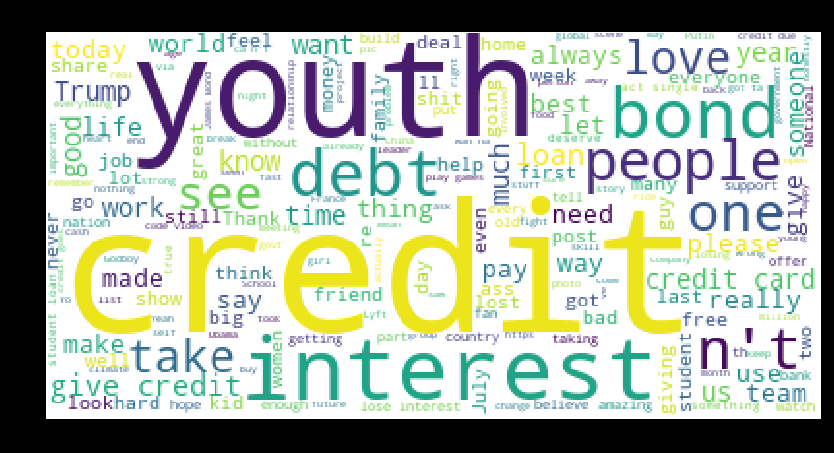

In [110]:
# Word Cloud visualization
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcloud(tweets,col):
    stopwords = set(STOPWORDS).union(set(["new" , "amp", "il", "da", "al", "del", "di", "la", "per"]))
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate('. '.join(cleaned_tweets))
    plt.figure( figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Good Morning Datascience+")
    plt.show()

wordcloud(cleaned_tweets,'text')

In [111]:
# Topic Modeling on cleaned_tweets
cleaned_tweets_doc = '. '.join(cleaned_tweets)

#Cleaning and Preprocessing

stop = set(stopwords.words('english') + ["rt"] + ["amp"] + ["u"] + ["it"])
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in cleaned_tweets_doc] 

In [112]:
#Prepare Doc-Term Matrix

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [113]:
#Run LDA
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

In [114]:
ldamodel.print_topics(num_topics = 5, num_words=3)

[(0, '0.490*"n" + 0.350*"l" + 0.115*"b"'),
 (1, '0.575*"r" + 0.246*"g" + 0.154*"f"'),
 (2, '0.962*"e" + 0.021*"j" + 0.008*"1"'),
 (3, '0.389*"h" + 0.342*"p" + 0.199*"w"'),
 (4, '0.483*"c" + 0.170*"k" + 0.155*"v"')]

#### 5e. Hashtag Analysis

In [115]:
data_kp = [i['text'] for i in ibm_kp]
data_kp = [i.lower() for i in data_kp]

terms = data_con
phrases = data_kp
all_terms = terms + phrases

In [117]:
tweets_keyconcepts = get_tweets(' OR '.join([f'"{term}"' for term in all_terms]))

In [118]:
#Store tweets data in a dataframe

def tweets_df(results):
    id_list = [tweet.id for tweet  in results]
    data_set = pd.DataFrame(id_list, columns = ["id"])
    
    data_set["text"] = [tweet.text for tweet in results]
    data_set["created_at"] = [tweet.created_at for tweet in results]
    data_set["retweet_count"] = [tweet.retweet_count for tweet in results]
    data_set["user_screen_name"] = [tweet.author.screen_name for tweet in results]
    data_set["user_followers_count"] = [tweet.author.followers_count for tweet in results]
    data_set["user_location"] = [tweet.author.location for tweet in results]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in results]
    
    return data_set

data_set = tweets_df(tweets_keyconcepts)


# Remove tweets with duplicate text

text = data_set["text"]

for i in range(0,len(text)):
    txt = ' '.join(word for word in text[i] .split() if not word.startswith('https:'))
    data_set.set_value(i, 'text2', txt)
    
data_set.drop_duplicates('text2', inplace=True)
data_set.reset_index(drop = True, inplace=True)
data_set.drop('text', axis = 1, inplace = True)
data_set.rename(columns={'text2': 'text'}, inplace=True)

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [119]:
Htag_df = pd.DataFrame()
j = 0

for tweet in range(0,len(tweets_keyconcepts)):
    hashtag = tweets_keyconcepts[tweet].entities.get('hashtags')
    for i in range(0,len(hashtag)):
        Htag = hashtag[i]['text'] 
        Htag_df.set_value(j, 'Hashtag',Htag)
        j = j+1

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [120]:
#key concepts
Htag_df.apply(pd.value_counts).head(5)

,Hashtag
Fortnite,34
helsinki2018,12
Finland,12
ALDUB3Years,9
ASimpleFavor,6


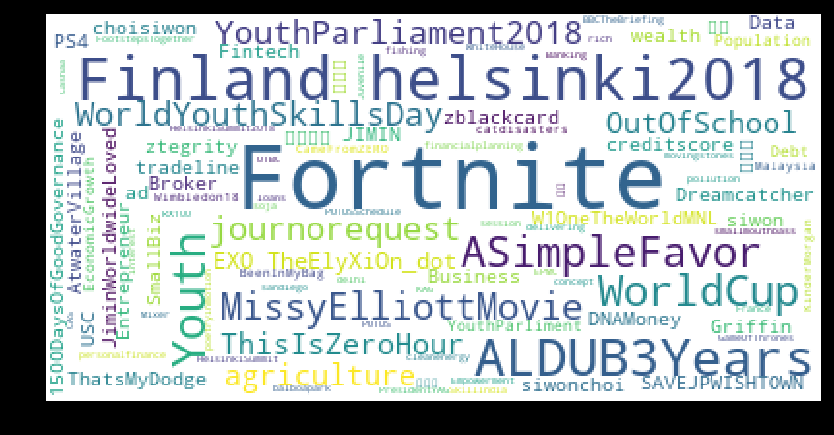

In [123]:
# Visualize
Hashtag_Combined = " ".join(Htag_df['Hashtag'].values.astype(str))

#Create a Word Cloud
wc = WordCloud(background_color="white", stopwords=STOPWORDS)
wc.generate(Hashtag_Combined)
plt.figure( figsize=(10,10), facecolor='k')
plt.imshow(wc)
plt.axis("off")
plt.show()

#### 5f. Semantic similarity of tweets with about us page

In [128]:
emb_tweets = [embed_text(i) for i in cleaned_tweets]

sims_tweets = [float(cosine_similarity(doc_emb, i.reshape(1,-1))) for i in emb_tweets]

#ranked_titles = [x for _,x in sorted(zip(sims_titles,titles), reverse = True)]
data = [[cleaned_tweets[i], sims_tweets[i]] for i in range(len(sims_tweets))]
df_rankedtweets = pd.DataFrame.from_records(data, columns = ['tweet', 'relevance']).sort_values(by = ['relevance'], ascending = False)
pd.set_option('max_colwidth', 800)
df_rankedtweets[:10]

,tweet,relevance
896,took million student loan denials finally get moneys,0.501999
336,": I took loan approved project terrace homes , builder giving flat b…",0.485098
597,. founder reaches initial deal $ 300m loan,0.472465
110,: I restricted wages poverty one year conjunction disability-related student loan forgiveness.…,0.469209
519,: US straight forward . always funding current account deficit selling portfolio debt ( net…,0.460622
742,Yo dad gave small loan million dollars I started company . IM SELF MADE BITCH,0.460334
172,": Idaho ,000 people student loan debt . Senator + share plan help :",0.453654
778,": By way , incredible work crowd sourcing bond money help parents begin reunification process…",0.453537
443,": The duty government leave commerce capital credit well branches business , pr…",0.452955
131,Well maybe I 'll pick Green Odell going spending cash pay school loans debt lol,0.450543
